In [1]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    rewards = tf.placeholder(tf.float32, [None], name='rewards')
    dones = tf.placeholder(tf.float32, [None], name='dones')
    rates = tf.placeholder(tf.float32, [None], name='rates') # success rate
    return states, actions, next_states, rewards, dones, rates

In [4]:
def Act(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Act', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        return logits

In [5]:
def Env(states, actions, state_size, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Env', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        states_logits = tf.layers.dense(inputs=nl2, units=state_size, trainable=False)
        Qlogits = tf.layers.dense(inputs=nl2, units=1, trainable=False)
        return states_logits, Qlogits

In [6]:
def model_loss(state_size, action_size, hidden_size, gamma,
               states, actions, next_states, rewards, dones, rates):
    ################################################ a = act(s)
    actions_logits = Act(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    aloss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels))
    ################################################ s', r = env(s, a)
    e_next_states_logits, eQs = Env(actions=actions_labels, states=states, hidden_size=hidden_size, 
                                    action_size=action_size, state_size=state_size)
    a_next_states_logits, aQs = Env(actions=actions_logits, states=states, hidden_size=hidden_size, 
                                    action_size=action_size, state_size=state_size, reuse=True)
    next_states_labels = tf.nn.sigmoid(next_states)
    eloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=e_next_states_logits, # GQN
                                                                   labels=next_states_labels))
    eloss += -tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=a_next_states_logits, 
                                                                     labels=next_states_labels)) # maximize loss
    aloss2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=a_next_states_logits, 
                                                                    labels=next_states_labels)) # minimize loss
    #################################################### s'', Q' = ~env(s', ~a')
    next_actions_logits = Act(states=next_states, hidden_size=hidden_size, action_size=action_size, reuse=True)
    next_states_logits, aQs2 = Env(actions=next_actions_logits, states=next_states, hidden_size=hidden_size, 
                                   action_size=action_size, state_size=state_size, reuse=True)
    eQs_logits = tf.reshape(eQs, shape=[-1])
    aQs_logits = tf.reshape(aQs, shape=[-1])
    aQs2_logits = tf.reshape(aQs2, shape=[-1]) * (1-dones)
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=eQs_logits, # GAN
                                                                    labels=rates)) # 0-1 real
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=(aQs_logits+aQs2_logits)/2, # GAN
                                                                    labels=tf.zeros_like(rates))) # min
    aloss2 += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=(aQs_logits+aQs2_logits)/2, # GAN
                                                                     labels=tf.ones_like(rates))) # max
    ###################################################### Q(s,a)= r + Q'(s',a')
    targetQs = rewards + (gamma * aQs2_logits) # DQN/Qlearning
    eloss += tf.reduce_mean(tf.square(eQs_logits - targetQs)) # real
    # eloss += tf.reduce_mean(tf.square(aQs_logits - rewards)) # min
    # aloss2 += tf.reduce_mean(tf.square(aQs_logits - targetQs)) # max
    eloss += tf.reduce_mean((aQs_logits+aQs2_logits)/2) # min
    aloss2 += -tf.reduce_mean((aQs_logits+aQs2_logits)/2) # max
    return actions_logits, aloss, eloss, aloss2

In [7]:
def model_opt(a_loss, e_loss, a_loss2, a_learning_rate, e_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    a_vars = [var for var in t_vars if var.name.startswith('Act')]
    e_vars = [var for var in t_vars if var.name.startswith('Env')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        a_opt = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss, var_list=a_vars)
        e_opt = tf.train.AdamOptimizer(e_learning_rate).minimize(e_loss, var_list=e_vars)
        a_opt2 = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss2, var_list=a_vars)
    return a_opt, e_opt, a_opt2

In [8]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, a_learning_rate, e_learning_rate, gamma):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.next_states, self.rewards, self.dones, self.rates = model_input(
            state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.a_loss, self.e_loss, self.a_loss2 = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, gamma=gamma, # model init
            states=self.states, actions=self.actions, next_states=self.next_states, 
            rewards=self.rewards, dones=self.dones, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.a_opt, self.e_opt, self.a_opt2 = model_opt(a_loss=self.a_loss, 
                                                        e_loss=self.e_loss,
                                                        a_loss2=self.a_loss2, 
                                                        a_learning_rate=a_learning_rate,
                                                        e_learning_rate=e_learning_rate)

In [9]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), size=batch_size, replace=False)
#         return [self.buffer[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [10]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [11]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
a_learning_rate = 1e-4         # Q-network learning rate
e_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size
gamma=0.99

In [12]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size, gamma=gamma,
              a_learning_rate=a_learning_rate, e_learning_rate=e_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [13]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    rate = -1
    memory.buffer.append([state, action, next_state, reward, float(done), rate])
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        #print(done)
        rate = total_reward/500
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1:
                memory.buffer[-1-idx][-1] = rate
        state = env.reset()
        total_reward = 0 # reset
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [14]:
def minibacth(memory):
    # Training with the maxrated minibatch
    batch = memory.buffer
    #for idx in range(memory_size// batch_size):
    while True:
        idx = np.random.choice(np.arange(memory_size// batch_size))
        states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        rates = np.array([each[5] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        states = states[rates >= np.max(rates)]
        actions = actions[rates >= np.max(rates)]
        next_states = next_states[rates >= np.max(rates)]
        rewards = rewards[rates >= np.max(rates)]
        dones = dones[rates >= np.max(rates)]
        rates = rates[rates >= np.max(rates)]
        if np.count_nonzero(dones) > 0 and len(dones) > 1 and np.max(rates) > 0:
            break
    return states, actions, next_states, rewards, dones, rates

In [15]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
aloss_list, eloss_list, aloss2_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes for running average/running mean/window

    # Training episodes/epochs
    for ep in range(11111):
        aloss_batch, eloss_batch, aloss2_batch = [], [], []
        total_reward = 0
        state = env.reset()
        rate = -1

        # Training steps/batches
        for num_step in range(11111):
            # Explore (env) or Exploit (model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done), rate])
            total_reward += reward
            state = next_state
            
            # Online policy/on-policy/online training
            states, actions, next_states, rewards, dones, rates = minibacth(memory=memory)
            feed_dict = {model.states: states, model.actions: actions, model.next_states: next_states,
                         model.rewards: rewards, model.dones: dones, model.rates: rates}
            aloss, _ = sess.run([model.a_loss, model.a_opt], feed_dict)
            eloss, _ = sess.run([model.e_loss, model.e_opt], feed_dict)
            aloss2, _= sess.run([model.a_loss2, model.a_opt2], feed_dict)
            aloss_batch.append(aloss)
            eloss_batch.append(eloss)
            aloss2_batch.append(aloss2)
            
            # End of episode/result/success rate available
            if done is True:
                # Rating the latest played episode
                rate = total_reward/500 # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.buffer[-1-idx][-1] == -1: # double-check the landmark/marked indexes
                        memory.buffer[-1-idx][-1] = rate # rate the trajectory/data
                break

        # Print out
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'aloss:{:.4f}'.format(np.mean(aloss_batch)),
              'eloss:{:.4f}'.format(np.mean(eloss_batch)),
              'aloss2:{:.4f}'.format(np.mean(aloss2_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        aloss_list.append([ep, np.mean(aloss_batch)])
        eloss_list.append([ep, np.mean(eloss_batch)])
        aloss2_list.append([ep, np.mean(aloss2_batch)])
        
        # Break episode/epoch loop
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of 500 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:19.0000 R:19.0000 rate:0.0380 aloss:0.6929 eloss:2.2050 aloss2:1.4432 exploreP:0.9981
Episode:1 meanR:19.5000 R:20.0000 rate:0.0400 aloss:0.6900 eloss:2.1786 aloss2:1.4563 exploreP:0.9961
Episode:2 meanR:33.0000 R:60.0000 rate:0.1200 aloss:0.6851 eloss:2.2041 aloss2:1.4461 exploreP:0.9902
Episode:3 meanR:34.5000 R:39.0000 rate:0.0780 aloss:0.6905 eloss:2.1741 aloss2:1.4598 exploreP:0.9864
Episode:4 meanR:30.2000 R:13.0000 rate:0.0260 aloss:0.6828 eloss:2.1717 aloss2:1.4640 exploreP:0.9852
Episode:5 meanR:27.6667 R:15.0000 rate:0.0300 aloss:0.6813 eloss:2.1967 aloss2:1.4488 exploreP:0.9837
Episode:6 meanR:29.1429 R:38.0000 rate:0.0760 aloss:0.6797 eloss:2.2100 aloss2:1.4429 exploreP:0.9800
Episode:7 meanR:30.5000 R:40.0000 rate:0.0800 aloss:0.6829 eloss:2.1665 aloss2:1.4692 exploreP:0.9761
Episode:8 meanR:29.5556 R:22.0000 rate:0.0440 aloss:0.6873 eloss:2.1789 aloss2:1.4640 exploreP:0.9740
Episode:9 meanR:29.9000 R:33.0000 rate:0.0660 aloss:0.6846 eloss:2.1645 aloss2:1.4

Episode:80 meanR:33.1111 R:22.0000 rate:0.0440 aloss:0.6667 eloss:0.7724 aloss2:3.2144 exploreP:0.7671
Episode:81 meanR:32.9512 R:20.0000 rate:0.0400 aloss:0.6748 eloss:0.7450 aloss2:3.2071 exploreP:0.7656
Episode:82 meanR:32.8675 R:26.0000 rate:0.0520 aloss:0.6853 eloss:0.7594 aloss2:3.2576 exploreP:0.7636
Episode:83 meanR:33.0476 R:48.0000 rate:0.0960 aloss:0.6785 eloss:0.8244 aloss2:3.2438 exploreP:0.7600
Episode:84 meanR:32.8588 R:17.0000 rate:0.0340 aloss:0.6830 eloss:0.8536 aloss2:3.2304 exploreP:0.7587
Episode:85 meanR:33.2907 R:70.0000 rate:0.1400 aloss:0.6723 eloss:0.8447 aloss2:3.2881 exploreP:0.7535
Episode:86 meanR:33.3103 R:35.0000 rate:0.0700 aloss:0.6686 eloss:0.9667 aloss2:3.2333 exploreP:0.7509
Episode:87 meanR:33.3182 R:34.0000 rate:0.0680 aloss:0.6786 eloss:0.9303 aloss2:3.3221 exploreP:0.7484
Episode:88 meanR:34.0000 R:94.0000 rate:0.1880 aloss:0.6733 eloss:1.0022 aloss2:3.3063 exploreP:0.7415
Episode:89 meanR:33.9667 R:31.0000 rate:0.0620 aloss:0.6739 eloss:1.0210 

Episode:158 meanR:79.0500 R:387.0000 rate:0.7740 aloss:0.7072 eloss:-4.6955 aloss2:21.8162 exploreP:0.3910
Episode:159 meanR:80.6600 R:204.0000 rate:0.4080 aloss:0.7132 eloss:-4.7260 aloss2:22.8848 exploreP:0.3833
Episode:160 meanR:83.8600 R:349.0000 rate:0.6980 aloss:0.7087 eloss:-4.9633 aloss2:23.8749 exploreP:0.3705
Episode:161 meanR:85.7500 R:213.0000 rate:0.4260 aloss:0.7228 eloss:-4.4108 aloss2:24.6416 exploreP:0.3629
Episode:162 meanR:85.9000 R:82.0000 rate:0.1640 aloss:0.7668 eloss:-3.2252 aloss2:24.9916 exploreP:0.3600
Episode:163 meanR:88.4300 R:299.0000 rate:0.5980 aloss:0.7242 eloss:-5.3031 aloss2:25.2134 exploreP:0.3497
Episode:164 meanR:91.0300 R:386.0000 rate:0.7720 aloss:0.7152 eloss:-4.7701 aloss2:26.0549 exploreP:0.3368
Episode:165 meanR:94.7400 R:387.0000 rate:0.7740 aloss:0.7258 eloss:-4.9948 aloss2:26.7063 exploreP:0.3244
Episode:166 meanR:99.3700 R:500.0000 rate:1.0000 aloss:0.7359 eloss:-5.3021 aloss2:27.5789 exploreP:0.3091
Episode:167 meanR:102.9600 R:500.0000 

Episode:234 meanR:362.3800 R:500.0000 rate:1.0000 aloss:0.7129 eloss:-4.4654 aloss2:44.9634 exploreP:0.0243
Episode:235 meanR:365.5000 R:461.0000 rate:0.9220 aloss:0.7050 eloss:-3.5799 aloss2:44.8487 exploreP:0.0236
Episode:236 meanR:366.1900 R:216.0000 rate:0.4320 aloss:0.7260 eloss:-4.6274 aloss2:44.3651 exploreP:0.0233
Episode:237 meanR:366.8800 R:138.0000 rate:0.2760 aloss:0.7268 eloss:-4.4044 aloss2:44.4787 exploreP:0.0232
Episode:238 meanR:371.4200 R:500.0000 rate:1.0000 aloss:0.7009 eloss:-3.1721 aloss2:44.2945 exploreP:0.0225
Episode:239 meanR:376.2300 R:500.0000 rate:1.0000 aloss:0.6944 eloss:-3.5513 aloss2:44.0615 exploreP:0.0219
Episode:240 meanR:379.6600 R:500.0000 rate:1.0000 aloss:0.7036 eloss:-4.1446 aloss2:43.8638 exploreP:0.0213
Episode:241 meanR:384.1800 R:476.0000 rate:0.9520 aloss:0.6872 eloss:-4.1826 aloss2:43.7875 exploreP:0.0208
Episode:242 meanR:387.7900 R:478.0000 rate:0.9560 aloss:0.6775 eloss:-3.9832 aloss2:43.9175 exploreP:0.0203
Episode:243 meanR:390.8600 R

Episode:310 meanR:447.2800 R:500.0000 rate:1.0000 aloss:0.5954 eloss:-1.0547 aloss2:37.4030 exploreP:0.0105
Episode:311 meanR:447.0600 R:380.0000 rate:0.7600 aloss:0.5913 eloss:-1.0254 aloss2:37.0969 exploreP:0.0105
Episode:312 meanR:450.2400 R:500.0000 rate:1.0000 aloss:0.6128 eloss:-1.4827 aloss2:37.2545 exploreP:0.0104
Episode:313 meanR:451.7100 R:500.0000 rate:1.0000 aloss:0.5733 eloss:-0.4279 aloss2:37.0439 exploreP:0.0104
Episode:314 meanR:452.1600 R:500.0000 rate:1.0000 aloss:0.5795 eloss:-0.8969 aloss2:36.8541 exploreP:0.0104
Episode:315 meanR:455.1800 R:500.0000 rate:1.0000 aloss:0.5849 eloss:-0.8062 aloss2:36.5259 exploreP:0.0104
Episode:316 meanR:455.1800 R:500.0000 rate:1.0000 aloss:0.5697 eloss:-0.5679 aloss2:36.5739 exploreP:0.0104
Episode:317 meanR:455.1800 R:500.0000 rate:1.0000 aloss:0.5788 eloss:-0.9812 aloss2:36.5134 exploreP:0.0103
Episode:318 meanR:455.1800 R:500.0000 rate:1.0000 aloss:0.5619 eloss:-0.5592 aloss2:36.5439 exploreP:0.0103
Episode:319 meanR:455.1800 R

Episode:387 meanR:484.9000 R:500.0000 rate:1.0000 aloss:0.4340 eloss:0.7699 aloss2:9.7086 exploreP:0.0100
Episode:388 meanR:484.9000 R:500.0000 rate:1.0000 aloss:0.4362 eloss:0.7822 aloss2:9.8543 exploreP:0.0100
Episode:389 meanR:484.9000 R:500.0000 rate:1.0000 aloss:0.4392 eloss:0.7824 aloss2:9.9963 exploreP:0.0100
Episode:390 meanR:484.9000 R:500.0000 rate:1.0000 aloss:0.4405 eloss:0.7886 aloss2:10.1104 exploreP:0.0100
Episode:391 meanR:484.9000 R:500.0000 rate:1.0000 aloss:0.4413 eloss:0.7903 aloss2:10.1771 exploreP:0.0100
Episode:392 meanR:484.9000 R:500.0000 rate:1.0000 aloss:0.4406 eloss:0.7881 aloss2:10.2364 exploreP:0.0100
Episode:393 meanR:484.9000 R:500.0000 rate:1.0000 aloss:0.4419 eloss:0.7782 aloss2:10.3598 exploreP:0.0100
Episode:394 meanR:489.2000 R:500.0000 rate:1.0000 aloss:0.4407 eloss:0.7935 aloss2:10.3834 exploreP:0.0100
Episode:395 meanR:489.2000 R:500.0000 rate:1.0000 aloss:0.4421 eloss:0.7677 aloss2:10.4435 exploreP:0.0100
Episode:396 meanR:489.2000 R:500.0000 ra

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

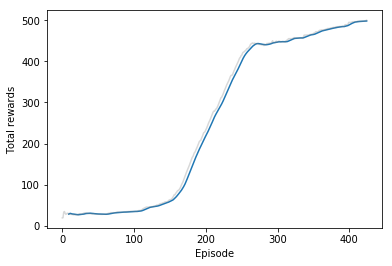

In [18]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

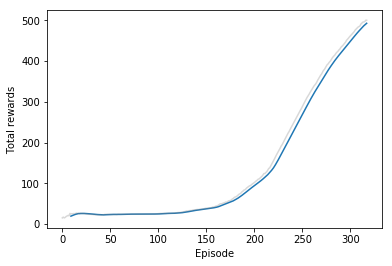

In [22]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

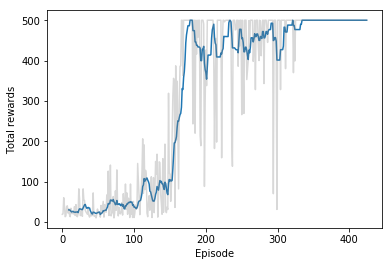

In [19]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

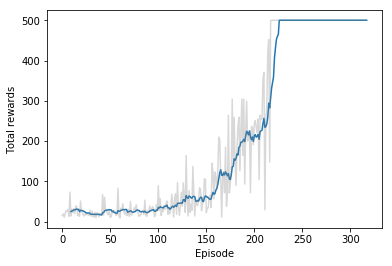

In [23]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Act losses')

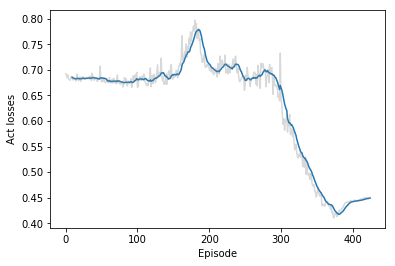

In [20]:
eps, arr = np.array(aloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses')

Text(0, 0.5, 'Act losses')

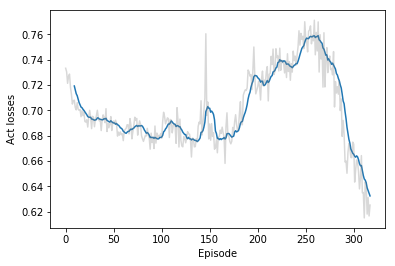

In [24]:
eps, arr = np.array(aloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses')

Text(0, 0.5, 'Env losses')

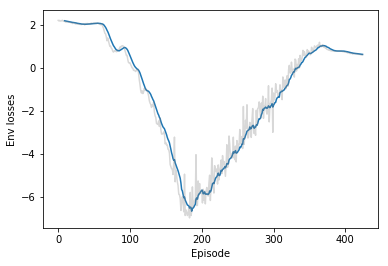

In [21]:
eps, arr = np.array(eloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Env losses')

Text(0, 0.5, 'Env losses')

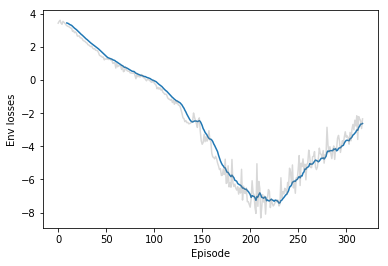

In [25]:
eps, arr = np.array(eloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Env losses')

Text(0, 0.5, 'Act losses 2')

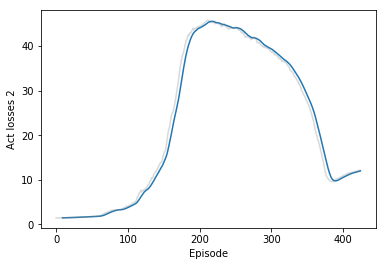

In [22]:
eps, arr = np.array(aloss2_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses 2')

Text(0, 0.5, 'Act losses 2')

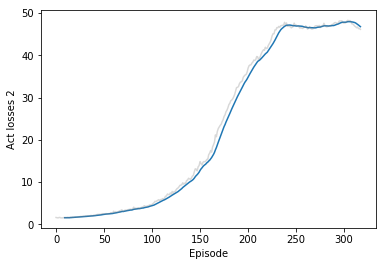

In [26]:
eps, arr = np.array(aloss2_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses 2')

## Testing

Let's checkout how our trained agent plays the game.

In [21]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
